In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set_style(style='dark')
sns.set_context("notebook")

In [85]:
telecom_data = pd.read_csv('telecom_churn_data.csv')

In [86]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [87]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
        "column":
        c,
        "percentage":
        round(100 * (df[c].isnull().sum() / len(df[c].index)), 2),
        "type":
        df[c].dtype
    } for c in df.columns
                if round(100 *
                         (df[c].isnull().sum() / len(df[c].index)), 2) > 0]
    
    if len(nan_cols)>0:
        return pd.DataFrame.from_records(nan_cols).sort_values(by=['percentage'],
                                                           ascending=False)
    else:
        return pd.DataFrame.from_records(nan_cols)


def convert_to_category(columns):
    for column in columns:
        telecom_data[column] = telecom_data[column].astype('object')


def get_int_float_columns_with_Zero_percentage(df):
    nan_cols = [{
        "column":
        c,
        "percentage":
        round(100 * ((df[c] == 0).sum() / len(df[c].index)), 2),
        "type":
        df[c].dtype
    } for c in df.columns
                if round(100 *
                         ((df[c] == 0).sum().sum() / len(df[c].index)), 2) > 0]
    return pd.DataFrame.from_records(nan_cols)


def get_columns_with_similar_values(df, threshold):
    columns_to_delete = []
    for c in df.columns:
        if (any(y > threshold for y in df[c].value_counts(
                dropna=False, normalize=True).tolist())):
            columns_to_delete.append(c)
    return columns_to_delete

## High value customers

In [88]:
## Columns: total_rech_data_6, av_rech_amt_data_6, total_rech_data_7 , av_rech_amt_data_7, total_rech_amt_6 and total_rech_amt_7 will be used to calcuate the high value customers.

# Filling NA values with 0

telecom_data[[
    'total_rech_data_6', 'av_rech_amt_data_6', 'total_rech_data_7',
    'av_rech_amt_data_7', 'total_rech_amt_6', 'total_rech_amt_7'
]] = telecom_data[[
    'total_rech_data_6', 'av_rech_amt_data_6', 'total_rech_data_7',
    'av_rech_amt_data_7', 'total_rech_amt_6', 'total_rech_amt_7'
]].fillna(0)


def get_average_recharge(row):
    amount = 0.0
    amount += row['total_rech_data_6'] * row['av_rech_amt_data_6']
    amount += row['total_rech_data_7'] * row['av_rech_amt_data_7']
    amount += row['total_rech_amt_6']
    amount += row['total_rech_amt_7']

    return amount / 2.0


telecom_data['average_recharge_amount'] = telecom_data.apply(
    get_average_recharge, axis=1)

In [89]:
percentile_70 = telecom_data['average_recharge_amount'].quantile(.7)
percentile_70

478.0

In [90]:
# As per the problem statement, we need to consider customers as high value if they have more than 70 percentile expense

def check_high_value_customer(row):
    return 1 if row['average_recharge_amount'] > percentile_70 else 0


telecom_data['high_value_customer'] = telecom_data.apply(
    check_high_value_customer, axis=1)

In [91]:
telecom_data['high_value_customer'].value_counts()

0    70046
1    29953
Name: high_value_customer, dtype: int64

We can see that there are **29953** high value customer. From now onwards, we will only consider these customers for further analysis.

In [92]:
# Getting all the high value customers
telecom_data = telecom_data[telecom_data['high_value_customer'] == 1]

In [93]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 228 entries, mobile_number to high_value_customer
dtypes: float64(180), int64(36), object(12)
memory usage: 52.3+ MB


## Churned customers

In [94]:
def check_churn(row):
     return 1 if (row['total_ic_mou_9'] == 0 and row['total_og_mou_9'] == 0 and row['vol_2g_mb_9'] == 0 and row['vol_3g_mb_9'] == 0)  else 0

telecom_data['churn'] = telecom_data.apply(check_churn, axis=1)
telecom_data['churn'] = telecom_data['churn'].astype('category')

In [95]:
telecom_data['churn'].value_counts()

0    27520
1     2433
Name: churn, dtype: int64

Now we will delete columns for **September**

In [96]:
columns_to_drop = [c for c in telecom_data.columns if c.endswith("_9")]
telecom_data = telecom_data.drop(columns_to_drop, axis=1)

In [97]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

,column,percentage,type
120,fb_user_8,46.8000,float64
114,arpu_2g_8,46.8000,float64
101,max_rech_data_8,46.8000,float64
107,count_rech_3g_8,46.8000,float64
108,av_rech_amt_data_8,46.8000,float64
98,total_rech_data_8,46.8000,float64
97,date_of_last_rech_data_8,46.8000,object
104,count_rech_2g_8,46.8000,float64
111,arpu_3g_8,46.8000,float64
117,night_pck_user_8,46.8000,float64


In [98]:
telecom_data.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,average_recharge_amount,high_value_customer
count,29953.0000,29953.0000,29730.0000,29730.0000,29730.0000,29953.0000,29953.0000,29953.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29953.0000,29953.0000,29953.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29953.0000,29953.0000,29953.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29411.0000,29417.0000,28781.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,15935.0000,16740.0000,17038.0000,15935.0000,16740.0000,17038.0000,15935.0000,16740.0000,17038.0000,15935.0000,29953.0000,29953.0000,15935.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,29953.0000,16740.0000,17038.0000,15935.0000,16740.0000,17038.0000,15935.0000,16740.0000,17038.0000,15935.0000,29953.0000,29953.0

In [99]:
def segregate_columns(df, n=10):
    segregation = [{
        "col": c,
        "col_type": 'continuous' if df[c].nunique(dropna=False) > n else 'categorical',
        "unique_count": df[c].nunique(dropna=False),
         "na_percentage": round(100 * (df[c].isnull().sum() / len(df[c].index)), 2),
    } for c in df.columns]
    return pd.DataFrame.from_records(segregation).sort_values(by=['unique_count'],
                                                           ascending=True).reset_index()

In [100]:
segregate_columns(telecom_data)

,index,col,col_type,unique_count,na_percentage
0,1,circle_id,categorical,1,0.0000
1,173,high_value_customer,categorical,1,0.0000
2,5,last_date_of_month_6,categorical,1,0.0000
3,87,std_ic_t2o_mou_7,categorical,2,1.7900
4,88,std_ic_t2o_mou_8,categorical,2,3.9100
5,86,std_ic_t2o_mou_6,categorical,2,1.8100
6,49,std_og_t2c_mou_8,categorical,2,3.9100
7,48,std_og_t2c_mou_7,categorical,2,1.7900
8,47,std_og_t2c_mou_6,categorical,2,1.8100
9,174,churn,categorical,2,0.0000


We can see above that there are multiple numeric fields which have high percentage of NAN and other unique values are 0 and 1. We can fill 0 in place of NAN in such columns.

In [101]:
nan_df_numerical = nan_df[nan_df['type'] == 'float64']['column']
nan_df_numerical

120             fb_user_8
114             arpu_2g_8
101       max_rech_data_8
107       count_rech_3g_8
108    av_rech_amt_data_8
98      total_rech_data_8
104       count_rech_2g_8
111             arpu_3g_8
117      night_pck_user_8
115      night_pck_user_6
105       count_rech_3g_6
102       count_rech_2g_6
118             fb_user_6
112             arpu_2g_6
99        max_rech_data_6
109             arpu_3g_6
116      night_pck_user_7
106       count_rech_3g_7
119             fb_user_7
100       max_rech_data_7
110             arpu_3g_7
103       count_rech_2g_7
113             arpu_2g_7
52           spl_og_mou_8
46           std_og_mou_8
76       std_ic_t2f_mou_8
82           std_ic_mou_8
49           isd_og_mou_8
91            ic_others_8
73       std_ic_t2m_mou_8
64       loc_ic_t2f_mou_8
79       std_ic_t2o_mou_8
70       std_ic_t2t_mou_8
55            og_others_8
67           loc_ic_mou_8
58       loc_ic_t2t_mou_8
88           isd_ic_mou_8
85           spl_ic_mou_8
61       loc

We can see that there are many columns which are float and have NAN. We can fill them with 0

In [102]:
telecom_data[nan_df_numerical] = telecom_data[nan_df_numerical].fillna(0)

In [103]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

,column,percentage,type
7,date_of_last_rech_data_8,46.8000,object
5,date_of_last_rech_data_6,44.1100,object
6,date_of_last_rech_data_7,43.1200,object
4,date_of_last_rech_8,1.9400,object
1,last_date_of_month_8,0.5500,object
3,date_of_last_rech_7,0.3300,object
2,date_of_last_rech_6,0.2400,object
0,last_date_of_month_7,0.0900,object


In [104]:
columns_with_more_than_70_percent_same_value = get_columns_with_similar_values(telecom_data,.70)
columns_with_more_than_70_percent_same_value

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet

In [105]:
columns_with_more_than_70_percent_same_value.remove('churn')

In [106]:
print(columns_with_more_than_70_percent_same_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7

In [107]:
telecom_data = telecom_data.drop(columns_with_more_than_70_percent_same_value,
                                 axis=1)

In [108]:
telecom_data.shape

(29953, 113)

In [109]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

,column,percentage,type
5,date_of_last_rech_data_8,46.8000,object
3,date_of_last_rech_data_6,44.1100,object
4,date_of_last_rech_data_7,43.1200,object
2,date_of_last_rech_8,1.9400,object
1,date_of_last_rech_7,0.3300,object
0,date_of_last_rech_6,0.2400,object


We will be deleting the date columns as there is no significance use of these columns and we have multiple other columns which have correlation with them like number of recharge etc.

In [110]:
date_columns_to_drop = [c for c in telecom_data.columns if "date" in c]
telecom_data = telecom_data.drop(date_columns_to_drop, axis=1)

## New derived features

In [111]:
# Creating new columns for the month wise amount spent
def month_wise_amount_spent(row, month):
    return row['total_rech_amt_' + month] + (row['total_rech_data_' + month] *
                                             row['av_rech_amt_data_' + month])

In [112]:
telecom_data['total_amount_spent_6'] = telecom_data.apply(
    month_wise_amount_spent, args=('6'), axis=1)
telecom_data['total_amount_spent_7'] = telecom_data.apply(
    month_wise_amount_spent, args=('7'), axis=1)
telecom_data['total_amount_spent_8'] = telecom_data.apply(
    month_wise_amount_spent, args=('8'), axis=1)

Now we can delete the columns which we used to calculate the total monthly amount.

In [113]:
telecom_data = telecom_data.drop([
    'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
    'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
    'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
    'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
    'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_data_6',
    'max_rech_data_7', 'max_rech_data_8'
],
                                 axis=1)

As we have added average amount for month of June and July, we can drop the total amount spent column.

In [114]:
telecom_data = telecom_data.drop(
    ['total_amount_spent_6', 'total_amount_spent_7'], axis=1)

In [115]:
telecom_data.shape

(29953, 90)

In [116]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

""


We can delete mobile number from the data set as it will not help in the analysis.

In [117]:
telecom_data = telecom_data.drop('mobile_number',axis=1)

## Analysis of the data
Reference for the following methods: https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#89dd and the previous assignments.

In [118]:
default_figsize = (15, 5)
default_xtick_angle = 50

In [119]:
def categorical_summarized(dataframe,
                           x=None,
                           y=None,
                           hue=None,
                           palette='Set1',
                           verbose=True,
                           figsize=default_figsize,
                           title="",
                           xlabel=None,
                           ylabel=None,
                           rotate_labels=False):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]

    if verbose:
        print(series.describe())
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())

    sns.set(rc={'figure.figsize': figsize})
    sorted_df = dataframe.sort_values(column_interested)
    ax = sns.countplot(x=x, y=y, hue=hue, data=sorted_df)

    plt.title(title)
    if not xlabel:
        xlabel = column_interested
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    total = len(dataframe[column_interested])
    if rotate_labels:
        plt.setp(ax.get_xticklabels(),
                 rotation=30,
                 horizontalalignment='right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [120]:
def quantitative_summarized(dataframe,
                            x=None,
                            y=None,
                            hue=None,
                            palette='Set1',
                            ax=None,
                            verbose=True,
                            swarm=False,
                            figsize=default_figsize):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    if verbose:
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())
    sns.set(rc={'figure.figsize': figsize})

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x,
                      y=y,
                      hue=hue,
                      data=dataframe,
                      palette=palette,
                      ax=ax)
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [121]:
def plot_column(df,
                col,
                chart_type='Hist',
                dtype=int,
                bins=25,
                figsize=default_figsize):
    temp_df = df[col]
    sns.set(rc={'figure.figsize': figsize})
    if chart_type == 'Hist':
        ax = sns.countplot(temp_df)
    elif chart_type == 'Dens':
        ax = sns.distplot(temp_df)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.round(np.linspace(xmin, xmax, bins), 2))
    plt.tight_layout()
    plt.locator_params(axis='y', nbins=6)
    plt.xticks(rotation=default_xtick_angle)
    plt.style.use('fivethirtyeight')
    plt.show()

In [122]:
def univariate_analysis(col,
                        chart_type='Dens',
                        df=telecom_data,
                        is_categorical=False,
                        title="",
                        xlabel=None,
                        ylabel=None,
                        rotate_labels=False,
                        bins=25):
    if is_categorical:
        categorical_summarized(df,
                               x=col,
                               title=title,
                               xlabel=xlabel,
                               ylabel=ylabel,
                               rotate_labels=rotate_labels,
                               verbose=False)
    else:
        quantitative_summarized(df, y=col, verbose=False)
        plot_column(df, col, chart_type=chart_type, bins=bins)

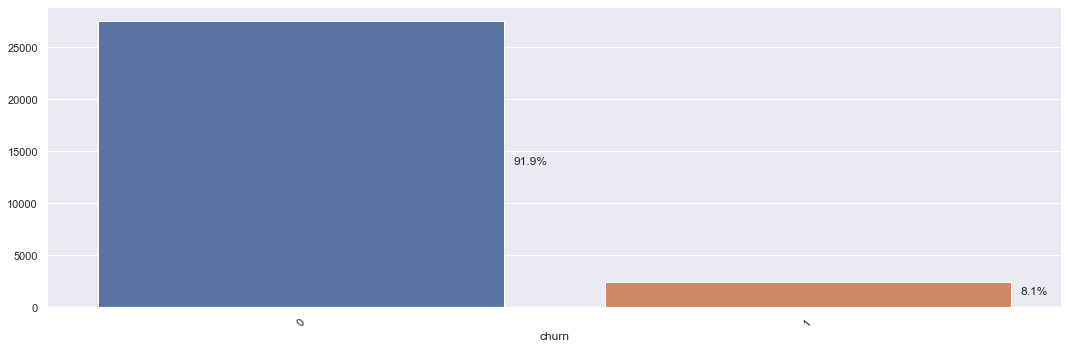

In [123]:
univariate_analysis('churn', is_categorical=True)

We can see that this data is highly imbalanced as the positive class (churn=1) is very less in number compared to negative class (churn=0). We will use class imbalance techniques like SMOTE to balance the data once we start with the model creation.

In [124]:
segregate_columns(telecom_data)

,index,col,col_type,unique_count,na_percentage
0,87,churn,categorical,2,0.0000
1,81,fb_user_8,categorical,2,0.0000
2,80,fb_user_7,categorical,2,0.0000
3,79,fb_user_6,categorical,2,0.0000
4,63,count_rech_2g_6,continuous,31,0.0000
5,65,count_rech_2g_8,continuous,34,0.0000
6,78,sachet_2g_7,continuous,35,0.0000
7,64,count_rech_2g_7,continuous,36,0.0000
8,61,last_day_rch_amt_7,continuous,152,0.0000
9,60,last_day_rch_amt_6,continuous,156,0.0000


In [125]:
telecom_data['fb_user_8'].value_counts()

0.0000    15656
1.0000    14297
Name: fb_user_8, dtype: int64

1. Univariate analysis
2. Binning of arpu_*, average_amount_
3. Binning of *_vbc_*